Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49
Generation 50
Generation 51
Generation 52
Generation 53
Generation 54
Generation 55
Generation 56
Generation 57
Generation 58
Generation 59
Generation 60
Generation 61
Generation 62
Generation 63
Generation 64
Generation 65
Generation 66
Generation 67
Generation 68
Generation 69
Generation 70
Generation 71
Generation 72
G

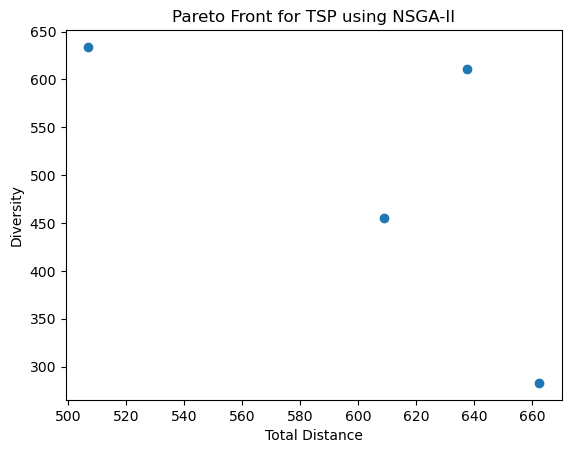

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Problem Setup
num_cities = 10
city_coords = np.random.rand(num_cities, 2) * 100

# Distance Matrix
def calculate_distance_matrix(coords):
    num = len(coords)
    distance_matrix = np.zeros((num, num))
    for i in range(num):
        for j in range(num):
            distance_matrix[i][j] = np.linalg.norm(coords[i] - coords[j])
    return distance_matrix

distance_matrix = calculate_distance_matrix(city_coords)

# Objective Functions
def total_distance(route):
    """Calculates the total distance of a TSP route."""
    dist = sum(distance_matrix[route[i], route[i+1]] for i in range(len(route)-1))
    dist += distance_matrix[route[-1], route[0]]  # Return to the start
    return dist

def diversity(route):
    """Maximizes diversity by ensuring distance among neighbors is balanced."""
    dist_var = np.var([distance_matrix[route[i], route[i+1]] for i in range(len(route)-1)])
    return dist_var

# NSGA-II Functions
def fast_non_dominated_sort(population):
    """Performs non-dominated sorting."""
    fronts = [[]]
    S, n, rank = {}, {}, {}
    for p in range(len(population)):
        S[p] = []
        n[p] = 0
        for q in range(len(population)):
            if dominates(population[p][1], population[q][1]):
                S[p].append(q)
            elif dominates(population[q][1], population[p][1]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            fronts[0].append(p)
    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    return fronts[:-1]

def dominates(a, b):
    """Check if solution a dominates solution b."""
    return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

def crowding_distance_assignment(front, solutions):
    """Assigns crowding distances."""
    distances = [0] * len(front)
    for i in range(len(solutions[0][1])):
        front.sort(key=lambda x: solutions[x][1][i])
        distances[0] = distances[-1] = float('inf')
        for j in range(1, len(front) - 1):
            distances[j] += (solutions[front[j+1]][1][i] - solutions[front[j-1]][1][i])
    return distances

# Genetic Algorithm Functions
def mutate(route):
    """Swap mutation for TSP."""
    a, b = random.sample(range(len(route)), 2)
    route[a], route[b] = route[b], route[a]
    return route

def crossover(parent1, parent2):
    """Order crossover for TSP."""
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))
    child_p1 = parent1[a:b+1]
    child = [item for item in parent2 if item not in child_p1]
    return child[:a] + child_p1 + child[a:]

# NSGA-II Main Loop
def nsga2_tsp(pop_size=50, generations=100):
    """NSGA-II for TSP problem."""
    # Initialize population
    population = [random.sample(range(num_cities), num_cities) for _ in range(pop_size)]
    solutions = [(route, [total_distance(route), diversity(route)]) for route in population]
    
    for gen in range(generations):
        print(f"Generation {gen+1}")
        # Non-dominated sorting
        fronts = fast_non_dominated_sort(solutions)
        new_population = []
        
        for front in fronts:
            if len(new_population) + len(front) <= pop_size:
                new_population.extend(front)
            else:
                crowding_distances = crowding_distance_assignment(front, solutions)
                sorted_front = [x for _, x in sorted(zip(crowding_distances, front), reverse=True)]
                new_population.extend(sorted_front[:pop_size - len(new_population)])
                break
        
        # Crossover and Mutation
        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = random.sample(new_population, 2)
            child = crossover(solutions[p1][0], solutions[p2][0])
            child = mutate(child)
            offspring.append((child, [total_distance(child), diversity(child)]))
        
        solutions = offspring
    
    # Return final solutions
    return solutions, fronts

# Run the algorithm
final_solutions, final_fronts = nsga2_tsp()

# Visualize the Pareto Front
pareto_front = [final_solutions[i][1] for i in final_fronts[0]]
plt.scatter(*zip(*pareto_front))
plt.xlabel("Total Distance")
plt.ylabel("Diversity")
plt.title("Pareto Front for TSP using NSGA-II")
plt.show()


In [8]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Problem Setup
num_nodes = 10  # Number of nodes
truck_nodes = random.sample(range(num_nodes), num_nodes // 2)  # Truck can visit only these nodes
q = 2  # UAV can visit at most 2 nodes consecutively before revisiting truck

# Generate random distance matrices for UAV and Truck
np.random.seed(42)
d_u = pd.DataFrame(np.random.randint(1, 100, (num_nodes, num_nodes)), columns=range(num_nodes), index=range(num_nodes))
d_t = pd.DataFrame(np.random.randint(1, 100, (num_nodes, num_nodes)), columns=range(num_nodes), index=range(num_nodes))

# Ensure diagonal distances are zero
np.fill_diagonal(d_u.values, 0)
np.fill_diagonal(d_t.values, 0)


In [32]:
def truck_distance(route):
    """Calculate total truck distance for given truck route."""
    dist = sum(d_t.loc[route[i], route[i + 1]] for i in range(len(route) - 1))
    return dist
def uav_distance(route):
    """Calculate total truck distance for given truck route."""
    dist = sum(d_u.loc[route[i], route[i + 1]] for i in range(len(route) - 1))
    return dist  

In [890]:
from copy import deepcopy as dc

def generate_solution(truck_nodes):
    """Generate a feasible solution for the truck and UAV."""
    truck_route = random.sample(truck_nodes, len(truck_nodes))
    uav_visits = {}
    for node in truck_route:
        uav_path = [n for n in range(num_nodes) if n not in truck_nodes and random.random() > 0.5]
        uav_path = uav_path[:q]  # Enforce UAV visit limit
        uav_visits[node] = uav_path
    return truck_route, uav_visits

def random_truck_sol(nodes):
    # Select between 1 and len(nodes[1:-1]) elements
    selected_nodes = random.sample(nodes[1:-1], k=random.randint(1, len(nodes[1:-1])))
    random.shuffle(selected_nodes)
    final_nodes = [nodes[0]] + selected_nodes + [nodes[-1]]  # Ensure first and last nodes remain
    return final_nodes

def random_uav_sol(a, c, q):
    # b = [x for x in a if x not in b]
    b = dc(c)
    b.pop()
    # Step 1: Randomly shuffle list a
    a_shuffled = a.copy()
    a_shuffled = a_shuffled
    random.shuffle(a_shuffled)
    
    # Step 2: Partition 'a' into random-sized chunks (size 1 to q)
    a_chunks = []
    i = 0
    while i < len(a_shuffled):
        chunk_size = random.randint(1, q)  # Random size between 1 and q
        a_chunks.append(a_shuffled[i:i+chunk_size])
        i += chunk_size
    # print('a_chunks',a_chunks)
    # Step 3: Interleave elements of b into a_chunks
    result = []
    b_index = 0
    for i in range(len(a_chunks)):
        result.extend(a_chunks[i])  # Add the chunk of 'a'
        # Add an element from b if available; otherwise, add 0
        if i == (len(a_chunks)-1):
            break
        elif b_index < len(b)-1:
            result.append(b[b_index+1])
            b_index += 1
        else:
            result.append(0)

    return [0] + result + [c[-1]]

def population(truck_nodes, uav_nodes, q, num_geration):
    temp = []
    for i in range(num_geration):
        random_tr = random_truck_sol(truck_nodes)
        uav_rem = [x for x in uav_nodes if x not in random_tr]
        temp.append([random_tr,random_uav_sol(uav_rem,random_tr,q)])
    return temp

In [826]:
# def random_uav_sol(uavNodes,Truck Nodes, q):

# [x for x in uav_nodes if x not in TruckNodes]
# selected_nodes = random.sample(nodes[1:-1], k=random.randint(1, len(nodes)))
# random.shuffle(selected_nodes)
# print(selected_nodes)
# final_nodes = [0] + selected_nodes + [nodes[-1]]
# print(final_nodes)


In [864]:
truck_nodes = [0, 1, 2, 3, 4, 5, 9]
uav_nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
q = 2

In [830]:
xx

[0, 3, 1, 4, 9]

In [886]:


# # random_generation
# zz = [x for x in uav_nodes if x not in xx]
# yy = random_uav_sol(uav_nodes, zz, q)
# # xx,zz,yy
# def sol_generator(truck_nodes,uav_nodes,q):





[[[0, 3, 1, 9], [0, 8, 5, 3, 7, 6, 1, 4, 2, 9]],
 [[0, 1, 2, 3, 4, 9], [0, 8, 5, 1, 6, 2, 7, 9]],
 [[0, 5, 1, 9], [0, 7, 5, 8, 1, 2, 0, 3, 0, 4, 6, 9]],
 [[0, 5, 4, 2, 1, 3, 9], [0, 8, 5, 7, 6, 9]],
 [[0, 4, 2, 5, 1, 3, 9], [0, 8, 4, 7, 2, 6, 9]],
 [[0, 4, 9], [0, 7, 2, 4, 5, 1, 0, 3, 8, 0, 6, 9]],
 [[0, 4, 3, 5, 2, 9], [0, 1, 4, 8, 3, 6, 5, 7, 9]],
 [[0, 1, 9], [0, 2, 8, 1, 6, 7, 0, 4, 0, 5, 0, 3, 9]],
 [[0, 3, 9], [0, 5, 3, 4, 8, 0, 1, 0, 7, 6, 0, 2, 9]],
 [[0, 5, 2, 9], [0, 4, 1, 5, 8, 3, 2, 6, 7, 9]],
 [[0, 1, 4, 9], [0, 7, 1, 3, 4, 8, 5, 0, 6, 0, 2, 9]],
 [[0, 4, 5, 2, 9], [0, 7, 4, 8, 1, 5, 6, 3, 9]],
 [[0, 2, 4, 3, 1, 5, 9], [0, 8, 6, 2, 7, 9]],
 [[0, 3, 5, 2, 9], [0, 7, 3, 6, 5, 8, 2, 4, 1, 9]],
 [[0, 4, 9], [0, 2, 4, 5, 7, 0, 1, 0, 8, 6, 0, 3, 9]],
 [[0, 3, 1, 4, 2, 9], [0, 5, 7, 3, 6, 1, 8, 9]],
 [[0, 2, 9], [0, 8, 1, 2, 4, 0, 5, 7, 0, 6, 0, 3, 9]],
 [[0, 1, 2, 4, 3, 9], [0, 6, 5, 1, 7, 2, 8, 9]],
 [[0, 1, 3, 9], [0, 5, 1, 6, 3, 8, 2, 0, 4, 7, 9]],
 [[0, 2, 9], [0, 3, 2, 7, 8

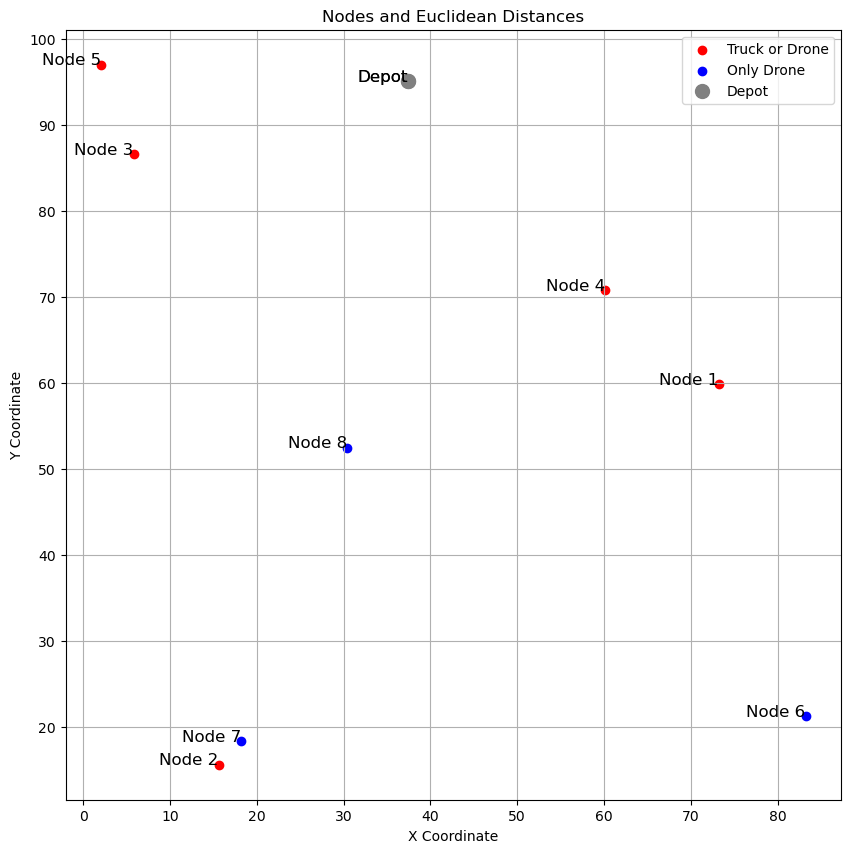

In [1234]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import time  # Add this at the top of your code
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata



N = 8  # Total number of aid recipients (bu UAV)
L = 5  # Number of aid recipients accessible by truck
R = 1  # Number of Trucks
V = 1  # Number of UAVs
q = 2  # Relief item capacity limit of UAVs. (unlimited)
#M = 10000  # A large number


A_T = (list(range(L+1)))+[N+1]  # Set of nodes for trucks
A_U = list(range(N+2))# Set of nodes for UAVs

T = list(range(1,R+1))      # Set of trucks
U = T

# Number of nodes
N += 1

np.random.seed(42)  # For reproducibility
coordinates = np.random.rand(N, 2) * 100  # Generate random coordinates in a 100x100 area

coordinates = np.vstack([coordinates, coordinates[0]])


euclidean_dist_matrix = distance_matrix(coordinates, coordinates)
manhattan_dist_matrix = distance_matrix(coordinates, coordinates, p=1)

euclidean_df = pd.DataFrame(euclidean_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])
manhattan_df = pd.DataFrame(manhattan_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])

plt.figure(figsize=(10, 10))
# plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red')
plt.scatter(coordinates[A_T[1:-1], 0], coordinates[A_T[1:-1], 1], color='red', label='Truck or Drone')
plt.scatter(coordinates[[item for item in A_U if item not in A_T], 0], coordinates[[item for item in A_U if item not in A_T], 1], color='blue', label='Only Drone')

# Highlight the first and last points as depots
plt.scatter(coordinates[0, 0], coordinates[0, 1], color='gray', s=100, label='Depot')
plt.scatter(coordinates[-1, 0], coordinates[-1, 1], color='gray', s=100)

# Annotate the nodes
for i, (x, y) in enumerate(coordinates):
    if i == 0:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    elif i == len(coordinates) - 1:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    else:
        plt.text(x, y, f'Node {i}', fontsize=12, ha='right')

# Draw lines between nodes for Euclidean distances
#for i in range(len(coordinates)):
 #   for j in range(i + 1, N+1):
  #      plt.plot([coordinates[i, 0], coordinates[j, 0]], [coordinates[i, 1], coordinates[j, 1]], 'gray', linestyle='--', linewidth=0.5)

plt.title('Nodes and Euclidean Distances')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()



d_t = manhattan_df  # Travel times for trucks => will change into a matrix of Manhttan distances
d_u = euclidean_df  # Travel times for UAVs => will change into a matrix of  Euclidean distances

max_d_t = d_t.values.max()
max_d_u = d_u.values.max()
M = (max(max_d_t, max_d_u) * (N + 1))  # N+1 for depot inclusion
# print('M is: ', M)


In [1235]:
d_u = d_u.to_numpy()
d_t = d_t.to_numpy()

In [1238]:
# d_t = np.random.randint(1, 50, size=(num_nodes, num_nodes))  # Truck distances
# d_u = np.random.randint(1, 30, size=(num_nodes, num_nodes))  # UAV distances
# np.fill_diagonal(d_t, 0)  # Diagonal = 0
# np.fill_diagonal(d_u, 0)
# d_t

In [1382]:
import random
import numpy as np
from copy import deepcopy as dc

# Distance Matrices (randomly generated for example)
# num_nodes = 15
# d_t = np.random.randint(1, 50, size=(num_nodes, num_nodes))  # Truck distances
# d_u = np.random.randint(1, 30, size=(num_nodes, num_nodes))  # UAV distances
# np.fill_diagonal(d_t, 0)  # Diagonal = 0
# np.fill_diagonal(d_u, 0)

# Truck and UAV nodes
truck_nodes = A_T
uav_nodes = A_U
q = 2  # UAV max consecutive nodes

# Objective Functions
def truck_distance(route):
    return sum(d_t[route[i], route[i + 1]] for i in range(len(route) - 1))

def uav_distance(route):
    return sum(d_u[route[i], route[i + 1]] for i in range(len(route) - 1))

def latest_node_visited(truck_route, uav_route):
    return max(truck_distance(truck_route[:-1]), uav_distance(uav_route[:-1]))

# Generate Random Solution
def random_truck_sol(nodes):
    selected_nodes = random.sample(nodes[1:-1], k=random.randint(1, len(nodes[1:-1])))
    random.shuffle(selected_nodes)
    return [nodes[0]] + selected_nodes + [nodes[-1]]

def random_uav_sol(a, c, q):
    b = dc(c)
    b.pop()
    a_shuffled = a.copy()
    random.shuffle(a_shuffled)
    a_chunks, i = [], 0
    while i < len(a_shuffled):
        chunk_size = random.randint(1, q)
        a_chunks.append(a_shuffled[i:i+chunk_size])
        i += chunk_size
    result, b_index = [], 0
    for chunk in a_chunks:
        result.extend(chunk)
        if b_index < len(b) - 1:
            result.append(b[b_index + 1])
            b_index += 1
        else:
            result.append(0)
    return [0] + result + [c[-1]]

def generate_population(truck_nodes, uav_nodes, q, size):
    population = []
    for _ in range(size):
        truck_route = random_truck_sol(truck_nodes)
        uav_rem = [x for x in uav_nodes if x not in truck_route]
        uav_route = random_uav_sol(uav_rem, truck_route, q)
        population.append([truck_route, uav_route])
    return population

# NSGA-II Functions
def dominates(obj1, obj2):
    return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

def non_dominated_sort(population):
    fronts = [[]]
    S, n, rank = {}, {}, {}
    for p in range(len(population)):
        S[p], n[p] = [], 0
        for q in range(len(population)):
            if dominates(population[p][2], population[q][2]):
                S[p].append(q)
            elif dominates(population[q][2], population[p][2]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            fronts[0].append(p)
    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    return fronts[:-1]

def evaluate_population(population):
    evaluated = []
    for truck_route, uav_route in population:
        dist = truck_distance(truck_route) + uav_distance(uav_route)
        latest = latest_node_visited(truck_route, uav_route)
        evaluated.append((truck_route, uav_route, [dist, latest]))
    return evaluated

# Main NSGA-II
def nsga2(truck_nodes, uav_nodes, q, pop_size=100, generations=50):
    population = generate_population(truck_nodes, uav_nodes, q, pop_size)
    solutions = evaluate_population(population)

    for gen in range(generations):
        # print(f"Generation {gen+1}")
        fronts = non_dominated_sort(solutions)
        new_population = []
        
        for front in fronts:
            if len(new_population) + len(front) <= pop_size:
                new_population.extend([solutions[i] for i in front])
            else:
                break
        
        # Mutation for the next generation
        population = generate_population(truck_nodes, uav_nodes, q, pop_size)
        solutions = evaluate_population(population)
    
    return solutions, fronts


def minimize_node_difference(truck_route, uav_route):
    """Minimize the difference between the latest and first visited nodes (excluding first/last truck nodes)."""
    truck_inner = truck_route[1:-1]  # Exclude first and last nodes
    uav_inner = uav_route[1:-1]  # Exclude first and last nodes
    
    truck_diff = abs(max(truck_inner) - min(truck_inner)) if truck_inner else 0
    uav_diff = abs(max(uav_inner) - min(uav_inner)) if uav_inner else 0

    return min(truck_diff, uav_diff)



# def evaluate_population(population):
#     evaluated = []
#     for truck_route, uav_route in population:
#         dist = truck_distance(truck_route) + uav_distance(uav_route)
#         latest = latest_node_visited(truck_route, uav_route)
#         diff = minimize_node_difference(truck_route, uav_route)  # Third objective
#         evaluated.append((truck_route, uav_route, [dist, latest, diff]))
#     return evaluated




In [1384]:
# a = generate_population(truck_nodes, uav_nodes, q, 100)

# evaluate_population(a)
# solutions

In [1386]:
# Run the Algorithm
solutions, fronts = nsga2(truck_nodes, uav_nodes, q)
# pareto_front = [solutions[i][2] for i in fronts[0]]
# pareto_front

In [1387]:
xx = [solutions[i][2] for i in range(len(solutions))]


In [1388]:
def dominates(solution1, solution2):
    """
    Check if solution1 dominates solution2.
    A solution dominates another if it is no worse in all objectives
    and strictly better in at least one.
    """
    return all(x <= y for x, y in zip(solution1, solution2)) and any(x < y for x, y in zip(solution1, solution2))

def find_pareto_front(solutions):
    """
    Find the Pareto front from a list of solutions.
    Each solution is a list of objective values.
    """
    pareto_front = []
    for solution in solutions:
        # Check if the solution is dominated by any in the current Pareto front
        is_dominated = False
        for other in pareto_front:
            if dominates(other, solution):
                is_dominated = True
                break
        # Remove dominated solutions already in the Pareto front
        pareto_front = [other for other in pareto_front if not dominates(solution, other)]
        # Add the current solution if it is not dominated
        if not is_dominated:
            pareto_front.append(solution)
    return pareto_front

# Example list of solutions (each sublist represents [objective1, objective2])
# solutions = [
#     [5, 10],
#     [6, 8],
#     [4, 12],
#     [7, 5],
#     [6, 6],
#     [3, 15],
# ]

# Find Pareto front
pareto_front = find_pareto_front(xx)

# # Display results
# print("All Solutions:")
# for sol in xx:
#     print(sol)

print("\nPareto Front:")
for sol in pareto_front:
    print(sol)



Pareto Front:
[637.0974305053377, 343.37140736195386]
[586.9286002861342, 445.0266712507497]
[683.1029244646986, 304.5251557931626]


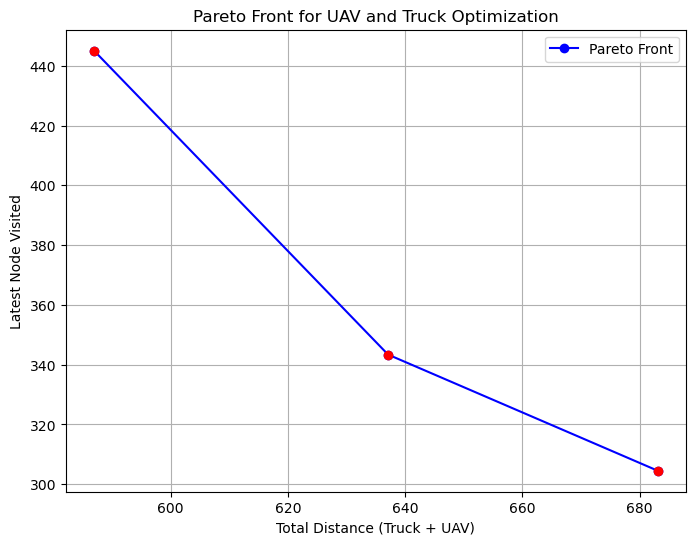

In [1392]:
# # Run the Algorithm
# solutions, fronts = nsga2(truck_nodes, uav_nodes, q)
# pareto_front = [solutions[i][2] for i in fronts[0]]

# Sort Pareto front for sequential line plotting
pareto_front = sorted(pareto_front)

# Extract X and Y coordinates
x_coords, y_coords = zip(*pareto_front)

# Plot the Pareto front
plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Pareto Front')  # Line plot
plt.scatter(x_coords, y_coords, color='red', zorder=3)  # Scatter plot over line plot for visibility

# Add labels and title
plt.xlabel("Total Distance (Truck + UAV)")
plt.ylabel("Latest Node Visited")
plt.title("Pareto Front for UAV and Truck Optimization")
plt.legend()
plt.grid(True)
plt.show()



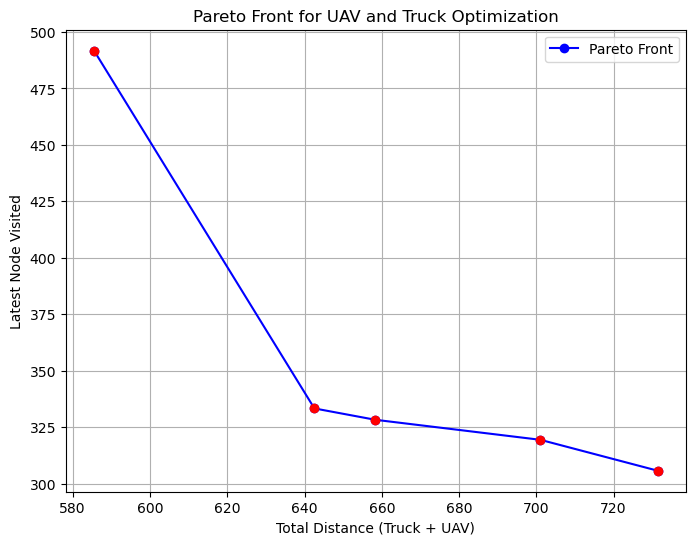

In [1380]:
# # Run the Algorithm
# solutions, fronts = nsga2(truck_nodes, uav_nodes, q)
# pareto_front = [solutions[i][2] for i in fronts[0]]

# Sort Pareto front for sequential line plotting
pareto_front = sorted(pareto_front)

# Extract X and Y coordinates
x_coords, y_coords = zip(*pareto_front)

# Plot the Pareto front
plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Pareto Front')  # Line plot
plt.scatter(x_coords, y_coords, color='red', zorder=3)  # Scatter plot over line plot for visibility

# Add labels and title
plt.xlabel("Total Distance (Truck + UAV)")
plt.ylabel("Latest Node Visited")
plt.title("Pareto Front for UAV and Truck Optimization")
plt.legend()
plt.grid(True)
plt.show()



In [1195]:

# # # Objective Functions
# # def truck_distance(route):
# #     """Calculate total truck distance for given truck route."""
# #     dist = sum(d_t.loc[route[i], route[i + 1]] for i in range(len(route) - 1))
# #     return dist

# # def uav_distance(truck_route, uav_visits):
# #     """Calculate total UAV distance given truck route and UAV visits."""
# #     total_dist = 0
# #     for i, truck_node in enumerate(truck_route):
# #         if truck_node in uav_visits:
# #             uav_path = uav_visits[truck_node]
# #             prev_node = truck_node  # UAV starts at truck node
# #             for uav_node in uav_path:
# #                 total_dist += d_u.loc[prev_node, uav_node]
# #                 prev_node = uav_node
# #             total_dist += d_u.loc[prev_node, truck_node]  # Return to truck
# #     return total_dist

# # def dependency_count(uav_visits):
# #     """Count the number of times UAV returns to the truck."""
# #     return sum(len(path) // q for path in uav_visits.values())

# # # Solution Representation
# # def generate_solution():
# #     """Generate a feasible solution for the truck and UAV."""
# #     truck_route = random.sample(truck_nodes, len(truck_nodes))
# #     uav_visits = {}
# #     for node in truck_route:
# #         uav_path = [n for n in range(num_nodes) if n not in truck_nodes and random.random() > 0.5]
# #         uav_path = uav_path[:q]  # Enforce UAV visit limit
# #         uav_visits[node] = uav_path
#     # return truck_route, uav_visits

# # NSGA-II Functions
# def dominates(a, b):
#     """Check if solution a dominates solution b."""
#     return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

# def fast_non_dominated_sort(population):
#     """Performs non-dominated sorting."""
#     fronts = [[]]
#     S, n, rank = {}, {}, {}
#     for p in range(len(population)):
#         S[p] = []
#         n[p] = 0
#         for q in range(len(population)):
#             if dominates(population[p][1], population[q][1]):
#                 S[p].append(q)
#             elif dominates(population[q][1], population[p][1]):
#                 n[p] += 1
#         if n[p] == 0:
#             rank[p] = 0
#             fronts[0].append(p)
#     i = 0
#     while fronts[i]:
#         Q = []
#         for p in fronts[i]:
#             for q in S[p]:
#                 n[q] -= 1
#                 if n[q] == 0:
#                     rank[q] = i + 1
#                     Q.append(q)
#         i += 1
#         fronts.append(Q)
#     return fronts[:-1]

# def mutate(truck_route, uav_visits):
#     """Mutation for the truck and UAV routes."""
#     a, b = random.sample(range(len(truck_route)), 2)
#     truck_route[a], truck_route[b] = truck_route[b], truck_route[a]
#     for key in uav_visits:
#         if uav_visits[key]:
#             random.shuffle(uav_visits[key])
#     return truck_route, uav_visits

# # NSGA-II Main Function
# def nsga2_vrp(pop_size=20, generations=50):
#     """NSGA-II for UAV and Truck VRP."""
#     # Initialize population
#     population = [generate_solution() for _ in range(pop_size)]
#     solutions = [(sol, [truck_distance(sol[0]), uav_distance(sol[0], sol[1]) + dependency_count(sol[1])]) for sol in population]

#     for gen in range(generations):
#         # print(f"Generation {gen+1}")
#         fronts = fast_non_dominated_sort(solutions)
#         new_population = []
        
#         for front in fronts:
#             if len(new_population) + len(front) <= pop_size:
#                 new_population.extend(front)
#             else:
#                 break
        
#         # Generate Offspring
#         offspring = []
#         while len(offspring) < pop_size:
#             p1, p2 = random.sample(new_population, 2)
#             child1, child2 = mutate(solutions[p1][0], solutions[p1][1]), mutate(solutions[p2][0], solutions[p2][1])
#             offspring.extend([
#                 (child1, [truck_distance(child1[0]), uav_distance(child1[0], child1[1]) + dependency_count(child1[1])]),
#                 (child2, [truck_distance(child2[0]), uav_distance(child2[0], child2[1]) + dependency_count(child2[1])])
#             ])
#         solutions = offspring[:pop_size]

#     return solutions, fronts

# # Run the NSGA-II Algorithm
# final_solutions, final_fronts = nsga2_vrp()

# # Visualize the Pareto Front
# pareto_front = [final_solutions[i][1] for i in final_fronts[0]]
# plt.scatter(*zip(*pareto_front))
# plt.xlabel("Truck Distance")
# plt.ylabel("UAV Distance + Dependency Count")
# plt.title("Pareto Front for UAV and Truck VRP")
# plt.show()


In [1368]:
solutions

[([0, 2, 4, 9],
  [0, 6, 8, 2, 1, 4, 7, 0, 5, 3, 0, 9],
  [751.1697554325833, 503.2065239576862]),
 ([0, 5, 3, 2, 9],
  [0, 4, 5, 8, 7, 3, 1, 6, 2, 9],
  [751.616397713241, 435.6206573804201]),
 ([0, 4, 9],
  [0, 3, 7, 4, 5, 2, 0, 6, 1, 0, 8, 0, 9],
  [755.082759345568, 661.2394350436246]),
 ([0, 1, 9],
  [0, 7, 1, 3, 0, 2, 4, 0, 6, 0, 5, 8, 0, 9],
  [886.913312825259, 745.0113837898746]),
 ([0, 1, 9],
  [0, 4, 5, 1, 7, 2, 0, 6, 3, 0, 8, 0, 9],
  [781.4757076837758, 639.5737786483913]),
 ([0, 3, 4, 1, 9],
  [0, 2, 8, 3, 6, 4, 7, 1, 5, 0, 9],
  [777.2861648219788, 572.0929344507617]),
 ([0, 1, 9],
  [0, 7, 8, 1, 3, 0, 6, 5, 0, 4, 2, 0, 9],
  [825.8586162766522, 683.9566872412678]),
 ([0, 4, 1, 5, 9],
  [0, 7, 4, 2, 1, 8, 3, 5, 6, 0, 9],
  [800.8221073732466, 584.2899442771345]),
 ([0, 2, 3, 1, 9],
  [0, 8, 2, 4, 3, 7, 6, 1, 5, 0, 9],
  [847.7434413994886, 500.51388594052503]),
 ([0, 2, 9],
  [0, 5, 2, 1, 0, 6, 3, 0, 4, 8, 0, 7, 0, 9],
  [933.8963217979947, 731.2480689022668]),
 ([0, 1, 

In [ ]:
a = [0,1,2,3,4]